<a href="https://colab.research.google.com/github/tesla1618/BeatsAI/blob/main/7272_BeatsAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import json
import os
import math
import librosa

In [ ]:
dataDir = "/content/drive/MyDrive/Data/genres_original"
jsonPath = "/content/data.json"
csvPath = "/content/drive/MyDrive/Data/features_30_sec.csv"

In [ ]:
df = pd.read_csv(csvPath)

In [ ]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
df['filename']

0      blues.00000.wav
1      blues.00001.wav
2      blues.00002.wav
3      blues.00003.wav
4      blues.00004.wav
            ...       
995     rock.00095.wav
996     rock.00096.wav
997     rock.00097.wav
998     rock.00098.wav
999     rock.00099.wav
Name: filename, Length: 1000, dtype: object

In [ ]:
DATASET_PATH = dataDir
JSON_PATH = jsonPath
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        try:
            if dirpath is not dataset_path:
                semantic_label = dirpath.split("/")[-1]
                data["mapping"].append(semantic_label)
                print("\nProcessing: {}".format(semantic_label))
                for f in filenames:
                    file_path = os.path.join(dirpath, f)
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                    for d in range(num_segments):
                        start = samples_per_segment * d
                        finish = start + samples_per_segment
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print("{}, segment:{}".format(file_path, d+1))
        except Exception as e:
            print(f"Error {e}")
            continue
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
# save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

In [188]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras


In [187]:
with open(jsonPath, "r") as fp:
  data = json.load(fp)

X = np.array(data["mfcc"])
y = np.array(data["labels"])

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [253]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),
    keras.layers.Dense(2048, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

In [254]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [255]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [256]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_15 (Flatten)        (None, 1690)              0         
                                                                 
 dense_138 (Dense)           (None, 2048)              3463168   
                                                                 
 dropout_81 (Dropout)        (None, 2048)              0         
                                                                 
 dense_139 (Dense)           (None, 1024)              2098176   
                                                                 
 dropout_82 (Dropout)        (None, 1024)              0         
                                                                 
 dense_140 (Dense)           (None, 512)               524800    
                                                                 
 dropout_83 (Dropout)        (None, 512)             

In [257]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=500)

Epoch 1/500
236/236 [==============================] - 4s 7ms/step - loss: 11.9945 - accuracy: 0.1510 - val_loss: 6.3871 - val_accuracy: 0.3369
Epoch 2/500
236/236 [==============================] - 1s 6ms/step - loss: 7.1892 - accuracy: 0.1941 - val_loss: 6.2986 - val_accuracy: 0.3480
Epoch 3/500
236/236 [==============================] - 1s 6ms/step - loss: 6.7022 - accuracy: 0.2386 - val_loss: 6.1627 - val_accuracy: 0.3951
Epoch 4/500
236/236 [==============================] - 1s 6ms/step - loss: 6.4287 - accuracy: 0.2780 - val_loss: 6.0734 - val_accuracy: 0.3904
Epoch 5/500
236/236 [==============================] - 1s 6ms/step - loss: 6.2852 - accuracy: 0.3017 - val_loss: 5.9253 - val_accuracy: 0.4237
Epoch 6/500
236/236 [==============================] - 2s 9ms/step - loss: 6.1443 - accuracy: 0.3197 - val_loss: 5.8572 - val_accuracy: 0.4206
Epoch 7/500
236/236 [==============================] - 2s 9ms/step - loss: 6.0200 - accuracy: 0.3431 - val_loss: 5.7743 - val_accuracy: 0.403

In [258]:
model.evaluate(X_test,y_test,verbose=0)

[1.5320723056793213, 0.727224588394165]

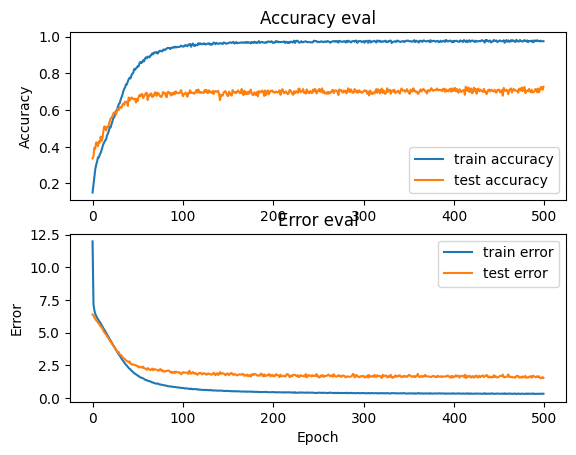

In [259]:
fig, axs = plt.subplots(2)
axs[0].plot(history.history["accuracy"], label="train accuracy")
axs[0].plot(history.history["val_accuracy"], label="test accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy eval")
#####ERROR#######################
axs[1].plot(history.history["loss"], label="train error")
axs[1].plot(history.history["val_loss"], label="test error")
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("Error eval")

plt.show()

In [243]:
# model_save_name = 'nn_7039_BeatsAI.keras'
# path = F"/content/drive/MyDrive/SavedModels/{model_save_name}"
# history.model.save(path)

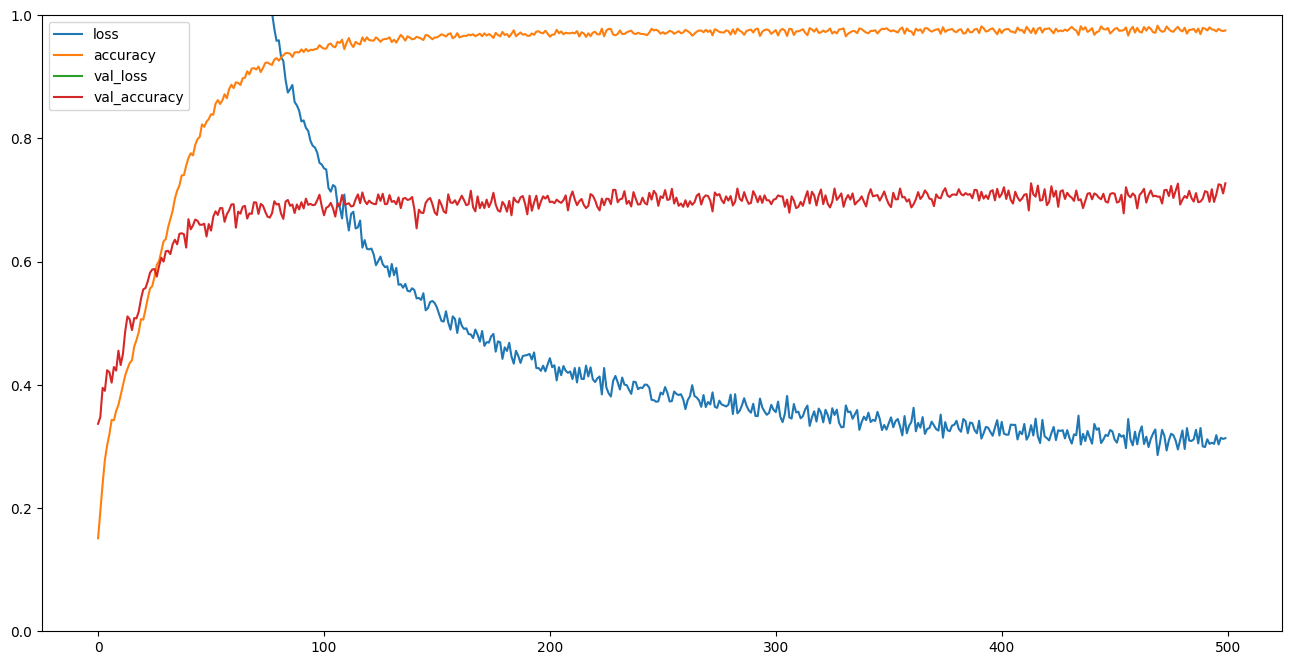

In [262]:
pd.DataFrame(history.history).plot(figsize=(16,8))
plt.ylim(0,1)
plt.show()